In [46]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
from IPython.display import display, clear_output
import ipywidgets as widgets
from pathlib import Path
import urllib.request

# Import SAM modules
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Set up matplotlib for inline display
%matplotlib inline

In [47]:
def download_sam_checkpoint(model_type="vit_b", checkpoint_dir="./checkpoints"):
    """
    Download SAM model checkpoint if not already present
    
    Parameters:
    - model_type: "vit_h", "vit_l", or "vit_b"
    - checkpoint_dir: directory to save the checkpoint
    """
    
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Model URLs
    model_urls = {
        "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
        "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
        "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
    }
    
    # Model file names
    model_files = {
        "vit_h": "sam_vit_h_4b8939.pth",
        "vit_l": "sam_vit_l_0b3195.pth",
        "vit_b": "sam_vit_b_01ec64.pth"
    }
    
    url = model_urls.get(model_type)
    filename = model_files.get(model_type)
    filepath = os.path.join(checkpoint_dir, filename)
    
    if not os.path.exists(filepath):
        print(f"Downloading {model_type} checkpoint...")
        urllib.request.urlretrieve(url, filepath)
        print(f"Downloaded to {filepath}")
    else:
        print(f"Checkpoint already exists at {filepath}")
    
    return filepath

In [48]:
def initialize_sam(model_type="vit_b", checkpoint_path=None, device=None):
    """
    Initialize the SAM model
    
    Parameters:
    - model_type: "vit_h", "vit_l", or "vit_b"
    - checkpoint_path: path to the model checkpoint
    - device: "cuda" for GPU or "cpu" for CPU
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    print(f"Using device: {device}")
    
    # If checkpoint_path is not provided, try to find it
    if checkpoint_path is None:
        checkpoint_dir = "./checkpoints"
        model_files = {
            "vit_h": "sam_vit_h_4b8939.pth",
            "vit_l": "sam_vit_l_0b3195.pth",
            "vit_b": "sam_vit_b_01ec64.pth"
        }
        checkpoint_path = os.path.join(checkpoint_dir, model_files.get(model_type, "sam_vit_h_4b8939.pth"))
    
    # Check if checkpoint exists
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(
            f"Checkpoint not found at {checkpoint_path}. "
            f"Please download it first using the download_sam_checkpoint() function."
        )
    
    # Load the model
    print(f"Loading SAM model ({model_type}) from {checkpoint_path}...")
    sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
    sam.to(device=device)
    
    print("SAM model loaded successfully!")
    return sam, device

In [49]:
download_sam_checkpoint()

Checkpoint already exists at ./checkpoints\sam_vit_b_01ec64.pth


'./checkpoints\\sam_vit_b_01ec64.pth'

In [50]:
initialize_sam

<function __main__.initialize_sam(model_type='vit_b', checkpoint_path=None, device=None)>

In [51]:
model_type = "vit_b"  # Change to "vit_l" or "vit_b" if needed

#checkpoint_path = "./checkpoints/sam_vit_h_4b8939.pth"  # Update path if needed
#checkpoint_path = "./checkpoints/sam_vit_l_0b3195.pth"  # Update path if needed
checkpoint_path = "./checkpoints/sam_vit_b_01ec64.pth"  # Update path if needed


sam, device = initialize_sam(model_type=model_type, checkpoint_path=checkpoint_path)

Using device: cuda
Loading SAM model (vit_b) from ./checkpoints/sam_vit_b_01ec64.pth...
SAM model loaded successfully!


In [52]:
def load_image(image_path):
    """Load an image from file path"""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [53]:
def display_image(image, title="Image", figsize=(10, 8)):
    """Display an image"""
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

Found 758 images in ./dataset/test_original:
  - frame_000142.png
  - frame_000154.png
  - frame_000184.png
  - frame_000195.png
  - frame_000212.png
  - frame_000226.png
  - frame_000236.png
  - frame_000260.png
  - frame_000263.png
  - frame_000269.png

Loading image: dataset\test_original\frame_000142.png


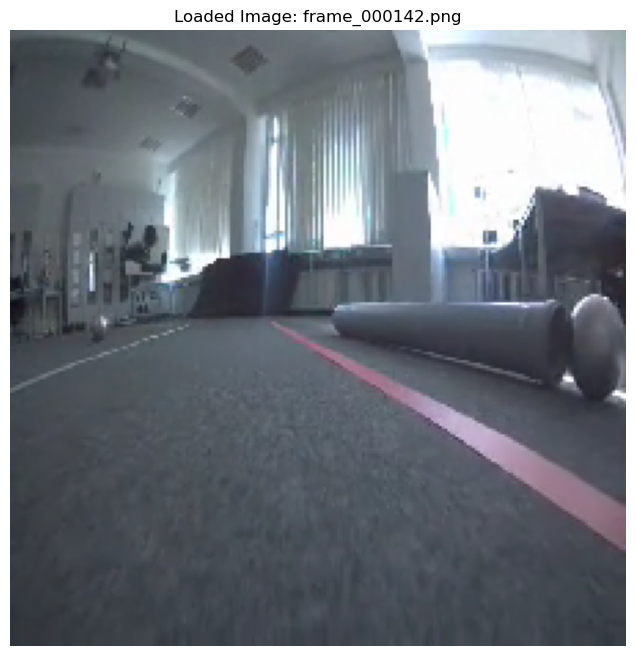

In [54]:
# Example: List images in a directory
image_dir = "./dataset/test_original"  # Change this to your image directory
os.makedirs(image_dir, exist_ok=True)

# List available images
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
image_files = []
for ext in image_extensions:
    image_files.extend(list(Path(image_dir).glob(f"*{ext}")))
    image_files.extend(list(Path(image_dir).glob(f"*{ext.upper()}")))

print(f"Found {len(image_files)} images in {image_dir}:")
for img_path in image_files[:10]:  # Show first 10
    print(f"  - {img_path.name}")

# Load and display an image if available
if image_files:
    # Load the first image
    image_path = str(image_files[0])
    print(f"\nLoading image: {image_path}")
    image = load_image(image_path)
    display_image(image, title=f"Loaded Image: {os.path.basename(image_path)}")

In [55]:
def generate_automatic_masks(image, sam_model, points_per_side=32, pred_iou_thresh=0.86, stability_score_thresh=0.92):
    """
    Generate masks for all objects in the image automatically
    
    Parameters:
    - image: input image (numpy array)
    - sam_model: initialized SAM model
    - points_per_side: controls density of sampling points
    - pred_iou_thresh: filter masks with IoU greater than this threshold
    - stability_score_thresh: filter masks with stability score greater than this threshold
    """
    # Initialize mask generator
    mask_generator = SamAutomaticMaskGenerator(
        model=sam_model,
        points_per_side=points_per_side,
        pred_iou_thresh=pred_iou_thresh,
        stability_score_thresh=stability_score_thresh,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=100,  # Filter out small disconnected regions
    )
    
    # Generate masks
    print("Generating masks...")
    masks = mask_generator.generate(image)
    print(f"Generated {len(masks)} masks")
    
    return masks

In [56]:
def show_anns(anns, image, figsize=(15, 10)):
    """Display masks over the image"""
    if len(anns) == 0:
        return
    
    # Sort masks by area (largest first)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    
    plt.figure(figsize=figsize)
    plt.imshow(image)
    
    # Create a transparent overlay for masks
    ax = plt.gca()
    ax.set_autoscale_on(False)
    
    # Add each mask with a random color
    for ann in sorted_anns:
        mask = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])  # Random color with transparency
        img = np.ones((mask.shape[0], mask.shape[1], 3))
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, mask * 0.35)))
    
    plt.title(f"Automatic Segmentation - {len(anns)} masks")
    plt.axis('off')
    plt.show()
    
    # Return the sorted annotations
    return sorted_anns

Generating masks...
Generated 71 masks


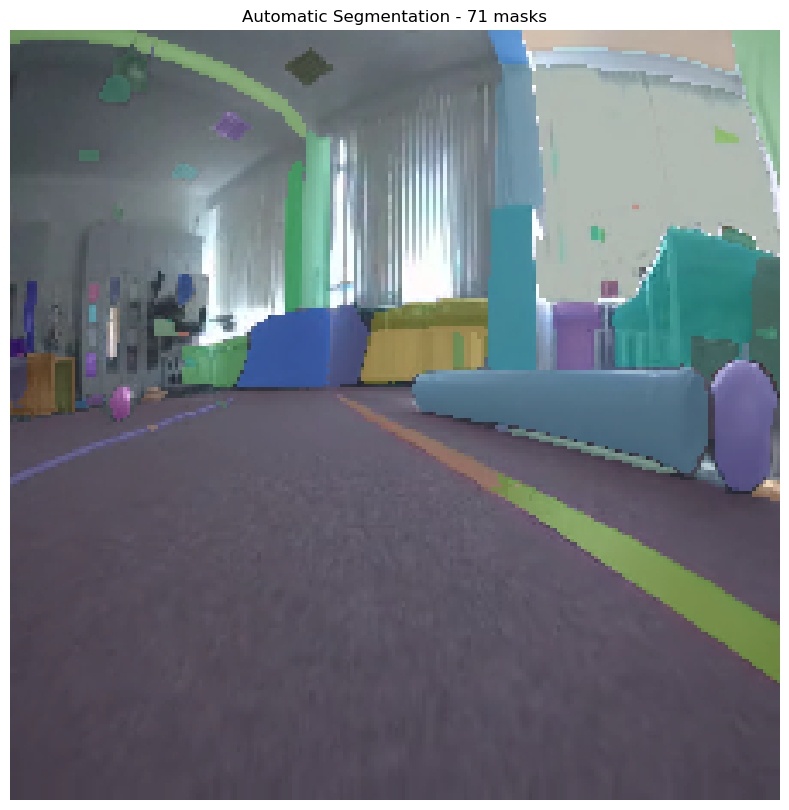


Mask details (top 5 by area):
Mask 1: Area = 23324, Bbox = [0, 104, 223, 119], Predicted IoU = 0.997
Mask 2: Area = 3573, Bbox = [152, 10, 71, 68], Predicted IoU = 0.937
Mask 3: Area = 2279, Bbox = [117, 96, 105, 37], Predicted IoU = 0.945
Mask 4: Area = 1664, Bbox = [117, 98, 85, 30], Predicted IoU = 0.978
Mask 5: Area = 1634, Bbox = [175, 57, 48, 47], Predicted IoU = 0.934


In [57]:
# Example: Generate and display automatic masks
if 'image' in locals() and image_files:
    # Generate masks
    masks = generate_automatic_masks(image, sam)
    
    # Display masks
    sorted_masks = show_anns(masks, image)
    
    # Display individual masks
    print("\nMask details (top 5 by area):")
    for i, mask in enumerate(sorted_masks[:5]):
        print(f"Mask {i+1}: Area = {mask['area']:.0f}, "
              f"Bbox = {mask['bbox']}, "
              f"Predicted IoU = {mask['predicted_iou']:.3f}")